In [ ]:
#pip install biolearn -U

In [1]:
import pandas as pd
from biolearn.data_library import DataLibrary
from biolearn.model_gallery import ModelGallery
gallery = ModelGallery()
from biolearn.model import DeconvolutionModel
import numpy as np
from scipy import stats
import time
import seaborn as sns
import matplotlib.pyplot as plt
data_path='/data/gladyshev/mm1286/data/'

dic={'cd4nv':'CD4nv',
     'cd4mem':'CD4mem',
     'treg':'Treg',
     'cd8nv':'CD8nv',
     'cd8mem':'CD8mem',
     'bnv':'Bnv',
     'bmem':'Bmem',
     'nk':'NK',
     'mono':'Mono',
     'neu':'Neu',
     'eos':'Eos',
     'bas':'Bas',
     'Baso':'Bas', 
     'Bn': 'Bnv',
     'CD4m':'CD4mem',
     'CD4n':'CD4nv',
     'EOS2':'Eos',
     'Tem0':'CD8mem',
     'Tn':'CD8nv',
    }

In [143]:
man=pd.read_csv(data_path+'/ref/man_e1.csv',index_col=0)
man.shape

(846233, 12)

In [83]:
#art mix
art = DataLibrary().get("GSE182379").load()
art.metadata=art.metadata.rename(columns=dic)

In [3]:
%%time
#sorted
mat2=data_path+'ref/cell_comp/GSE167998_matrix_processed.txt'
dnam2=pd.read_table(mat2,nrows=10**6,index_col=0,skiprows=0,usecols=[0]+list(range(1,136,2)))

CPU times: user 13.6 s, sys: 1.58 s, total: 15.2 s
Wall time: 18.1 s


In [4]:
meta2_='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE167nnn/GSE167998/matrix/GSE167998_series_matrix.txt.gz'
meta2=pd.read_table(meta2_,skiprows=38,index_col=0,nrows=1,header=None).T
meta2['!Sample_title']=meta2['!Sample_title'].str[:4]
meta2.index=dnam2.columns
meta2=meta2.squeeze()
meta_m2=meta2[meta2=='mem ']
meta2=meta2[meta2!='mem ']
meta2.loc[meta2.str[:2]=='Bn']='Bn'
meta2.loc[meta2.str[:2]=='Tn']='Tn'
meta2.loc[meta2.str[:2]=='NK']='NK'
meta2.loc[(meta2.str[:2]=='WB')|(meta2=='PCA0')|(meta2=='Neut')]='Neu'

In [254]:
%%time
meta_mix2=pd.read_table(meta2_,skiprows=39,index_col=0,nrows=50).iloc[34:47]
meta_mix2.columns=dnam2.columns
meta_mix2=meta_mix2[meta_m2.index]
meta_mix2.index=meta_mix2.iloc[:,0].str.split(': ').str[0]
for c in meta_mix2.columns:
    meta_mix2[c]=meta_mix2[c].str.split(': ').str[1].astype(float)
meta_mix2=meta_mix2.rename(index=dic)

CPU times: user 119 ms, sys: 2.97 ms, total: 122 ms
Wall time: 746 ms


In [255]:
meta_mix2

,204361730134_R08C01,204361730134_R05C01,204361730134_R03C01,204361730134_R02C01,204361730134_R01C01,204361720136_R07C01,204361720136_R06C01,204361720136_R05C01,204361720136_R04C01,204361720136_R03C01,204361720136_R02C01,204361720136_R01C01
204361730134_R08C01,,,,,,,,,,,,
Treg,0.000,0.125,0.101,0.160,0.152,0.060,0.100,0.000,0.111,0.000,0.000,0.036
CD4nv,0.108,0.184,0.105,0.033,0.140,0.080,0.148,0.168,0.099,0.057,0.088,0.089
CD4mem,0.208,0.000,0.082,0.000,0.054,0.000,0.114,0.078,0.000,0.130,0.089,0.163
cd4t,0.316,0.309,0.288,0.193,0.346,0.140,0.362,0.246,0.210,0.187,0.177,0.288
cd8t,0.162,0.158,0.154,0.140,0.150,0.138,0.112,0.113,0.203,0.209,0.110,0.183
Bnv,0.064,0.097,0.113,0.147,0.087,0.144,0.124,0.077,0.110,0.141,0.238,0.043
Bmem,0.044,0.163,0.165,0.051,0.073,0.112,0.036,0.133,0.075,0.084,0.087,0.074
bcell,0.108,0.260,0.278,0.198,0.160,0.256,0.160,0.210,0.185,0.225,0.325,0.117
NK,0.078,0.047,0.125,0.068,0.104,0.057,0.028,0.108,0.090,0.170,0.089,0.060


In [8]:
meta2=meta2.replace(dic)

In [9]:
dt=dnam2.T.join(meta2.rename('cell'),how='inner')

In [10]:
ref=dt.groupby('cell').mean().T


In [32]:
%%time
n=-1 
ps={}
for cell in list(dt['cell'].unique()):
    t0=time.time()
    ps[cell]=[]
    rvs1=dt[dt['cell']==cell]
    rvs2=dt[dt['cell']!=cell]
    for cg in dt.columns[:n]:
        ps[cell].append(stats.ttest_ind(rvs1[cg], rvs2[cg]).statistic)
    print(cell, ' ',(time.time()-t0)/60)        

/PHShome/mm1286/anaconda3/envs/p311/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


CD4nv   9.287379201253255
CD4mem   8.651944847901662
Bas   8.80765354235967
Bmem   8.812497047583262
Bnv   9.46589417854945
Treg   8.789982191721599
CD8mem   8.850065139929454
CD8nv   8.780399942398072
Eos   8.882055521011353
NK   8.789116700490316
Neu   8.666344463825226
Mono   8.90350779692332
CPU times: user 1h 45min 32s, sys: 57.9 s, total: 1h 46min 30s
Wall time: 1h 46min 41s


In [33]:
%%time
df=pd.DataFrame(ps,index=dt.columns[:-1])
df=df.rename(columns=dic)
df.to_csv(data_path+'comp/ss.csv')

CPU times: user 13 s, sys: 262 ms, total: 13.2 s
Wall time: 16.7 s


In [162]:
df=df[df.index.isin(man.index)]
df.shape

(846180, 12)

In [307]:
cgs=[]
n=100
for c in df.columns:
    cgs.append(pd.Series(df[c].sort_values().head(n).index,index=n*[c]))
    cgs.append(pd.Series(df[c].sort_values().tail(n).index,index=n*[c]))
cgs=pd.concat(cgs)

In [330]:
thre=10
cors=[]
for i,c in cgs.items():
    cors.append([c,art.metadata[[i]].corrwith(art.dnam.loc[c]).values[0]])
cors=pd.DataFrame(cors,index=cgs.index)
cors['c']=cors.index
cors['r']=cors[1].abs()
#corsf=cors[cors['r']>thre]#.groupby('c').size()
corstop=[]
for i in df.columns:
    corstop.append(pd.concat([cors[cors['c']==i].sort_values(1).head(thre),cors[cors['c']==i].sort_values(1).tail(thre)]))

In [331]:
corsf=pd.concat(corstop)

In [332]:
cgs=corsf[0]
len(cgs)

240

In [333]:
cgs=cgs.drop_duplicates()
cgs.shape

(240,)

In [377]:
ref.loc[cgs].to_csv('12.csv')

In [334]:
    dec = gallery.get("DeconvoluteBloodEPIC")
    dec.reference=ref.loc[cgs]
    pred = dec.predict(art)

In [335]:
corsm=[]
for c in pred.index:
    corsm.append(art.metadata[[c]].corrwith(pred.loc[c]).values[0])
corsm=pd.DataFrame(corsm,index=pred.index).sort_values(0)
print(corsm)

               0
cell            
CD4nv   0.950860
Bmem    0.973534
CD8mem  0.979990
CD4mem  0.982289
CD8nv   0.984117
Mono    0.985659
Treg    0.986146
Eos     0.988211
Neu     0.993216
Bas     0.996592
NK      0.997041
Bnv     0.997089


In [336]:
pl=art.metadata.copy()
obs=art.metadata.columns
pl.columns=[c+'_o' for c in obs]

In [337]:
pl=pl.join(pred.T)

In [338]:
pl=pl.melt(value_vars=obs,value_name='pred').join(pl.melt(value_vars=[c+'_o' for c in obs],var_name='ob_var',value_name='ob'))

In [339]:
pl['ob']=pl['ob'].astype(float)

<Axes: xlabel='ob', ylabel='pred'>

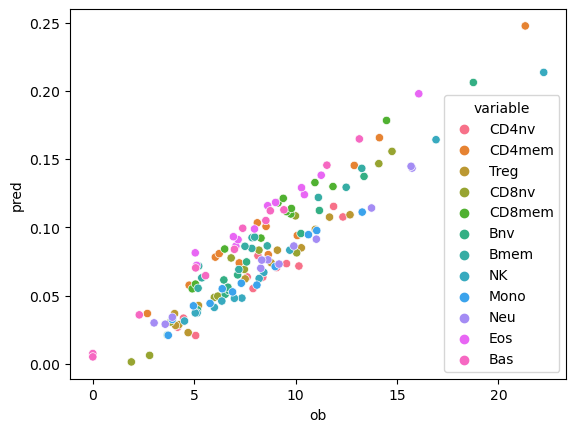

In [340]:
sns.scatterplot(data=pl,x='ob',y='pred',hue='variable')

In [357]:
#art mix
t = pd.read_table(data_path+'comp/GSE180683_Matrix_processed.txt',index_col=0,nrows=10**2,usecols=[0]+list(range(1,152,2)))

In [372]:
t_meta=pd.read_table('https://ftp.ncbi.nlm.nih.gov/geo/series/GSE180nnn/GSE180683/matrix/GSE180683_series_matrix.txt.gz',skiprows=39,index_col=0)

In [373]:
t_meta

,GSM5467948,GSM5467949,GSM5467950,GSM5467951,GSM5467952,GSM5467953,GSM5467954,GSM5467955,GSM5467956,GSM5467957,...,GSM5468014,GSM5468015,GSM5468016,GSM5468017,GSM5468018,GSM5468019,GSM5468020,GSM5468021,GSM5468022,GSM5468023
!Sample_geo_accession,,,,,,,,,,,,,,,,,,,,,
!Sample_status,Public on Feb 07 2022,Public on Feb 07 2022,Public on Feb 07 2022,Public on Feb 07 2022,Public on Feb 07 2022,Public on Feb 07 2022,Public on Feb 07 2022,Public on Feb 07 2022,Public on Feb 07 2022,Public on Feb 07 2022,...,Public on Feb 07 2022,Public on Feb 07 2022,Public on Feb 07 2022,Public on Feb 07 2022,Public on Feb 07 2022,Public on Feb 07 2022,Public on Feb 07 2022,Public on Feb 07 2022,Public on Feb 07 2022,Public on Feb 07 2022
!Sample_submission_date,Jul 22 2021,Jul 22 2021,Jul 22 2021,Jul 22 2021,Jul 22 2021,Jul 22 2021,Jul 22 2021,Jul 22 2021,Jul 22 2021,Jul 22 2021,...,Jul 22 2021,Jul 22 2021,Jul 22 2021,Jul 22 2021,Jul 22 2021,Jul 22 2021,Jul 22 2021,Jul 22 2021,Jul 22 2021,Jul 22 2021
!Sample_last_update_date,Feb 09 2022,Feb 09 2022,Feb 09 2022,Feb 09 2022,Feb 09 2022,Feb 09 2022,Feb 09 2022,Feb 09 2022,Feb 09 2022,Feb 09 2022,...,Feb 09 2022,Feb 09 2022,Feb 09 2022,Feb 09 2022,Feb 09 2022,Feb 09 2022,Feb 09 2022,Feb 09 2022,Feb 09 2022,Feb 09 2022
!Sample_type,genomic,genomic,genomic,genomic,genomic,genomic,genomic,genomic,genomic,genomic,...,genomic,genomic,genomic,genomic,genomic,genomic,genomic,genomic,genomic,genomic
!Sample_channel_count,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
!Sample_source_name_ch1,Human Peripheral Blood from Glioma Patient,Human Peripheral Blood from Glioma Patient,Human Peripheral Blood from Glioma Patient,Human Peripheral Blood from Glioma Patient,Human Peripheral Blood from Glioma Patient,Human Peripheral Blood from Glioma Patient,Human Peripheral Blood from Glioma Patient,Human Peripheral Blood from Glioma Patient,Human Peripheral Blood from Glioma Patient,Human Peripheral Blood from Glioma Patient,...,Human Peripheral Blood from Glioma Patient,Human Peripheral Blood from Glioma Patient,Human Peripheral Blood from Glioma Patient,Human Peripheral Blood from Glioma Patient,Human Peripheral Blood from Glioma Patient,Human Peripheral Blood from Glioma Patient,Human Peripheral Blood from Glioma Patient,Human Peripheral Blood from Glioma Patient,Human Peripheral Blood from Glioma Patient,Human Peripheral Blood from Glioma Patient
!Sample_organism_ch1,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,...,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens
!Sample_characteristics_ch1,diagnosis: Glioma,diagnosis: Glioma,diagnosis: Glioma,diagnosis: Glioma,diagnosis: Glioma,diagnosis: Glioma,diagnosis: Glioma,diagnosis: Glioma,diagnosis: Glioma,diagnosis: Glioma,...,diagnosis: Glioma,diagnosis: Glioma,diagnosis: Glioma,diagnosis: Glioma,diagnosis: Glioma,diagnosis: Glioma,diagnosis: Glioma,diagnosis: Glioma,diagnosis: Glioma,diagnosis: Glioma
!Sample_characteristics_ch1,tissue: Peripheral blood,tissue: Peripheral blood,tissue: Peripheral blood,tissue: Peripheral blood,tissue: Peripheral blood,tissue: Peripheral blood,tissue: Peripheral blood,tissue: Peripheral blood,tissue: Peripheral blood,tissue: Peripheral blood,...,tissue: Peripheral blood,tissue: Peripheral blood,tissue: Peripheral blood,tissue: Peripheral blood,tissue: Peripheral blood,tissue: Peripheral blood,tissue: Peripheral blood,tissue: Peripheral blood,tissue: Peripheral blood,tissue: Peripheral blood


In [360]:
art2=art.copy()

In [361]:
art2.dnam=t

In [363]:
art2.metadata

,CD4nv,CD4mem,Treg,CD8nv,CD8mem,Bnv,Bmem,NK,Mono,Neu,Eos,Bas
id,,,,,,,,,,,,
GSM5527895,4.47,10.08,10.28,5.99,10.95,6.53,13.26,6.36,6.89,3.02,9.01,13.14
GSM5527896,8.14,8.65,11.67,6.16,9.13,6.71,8.6,8.43,3.72,8.63,8.62,11.54
GSM5527897,10.16,21.32,12.68,2.8,11.84,3.68,11.12,5.14,3.92,3.57,5.05,8.75
GSM5527898,7.9,4.75,4.24,14.75,9.76,18.76,7.2,7.35,5.78,3.92,7.05,8.53
GSM5527899,7.61,6.04,8.79,8.19,8.29,5.16,5.22,22.23,8.09,8.28,5.12,6.98
GSM5527900,5.07,8.11,5.21,6.82,4.9,7.14,12.49,9.71,4.96,15.74,10.43,9.42
GSM5527901,9.55,8.54,7.51,9.99,9.55,6.46,7.85,4.52,13.28,9.18,11.26,2.29
GSM5527902,4.18,6.23,10.97,3.83,5.06,7.58,5.37,16.92,10.63,15.69,7.97,5.56
GSM5527903,8.38,14.13,4.08,1.9,6.5,11.17,7.84,8.2,6.38,13.74,10.29,7.39


In [362]:
dec.predict(art2)

ValueError: Invalid dimensions (0, 12).